---
title: Low performance genes
author: Sabrina Mi
date: 2/14/2024
---

## Performance of genes outside training set

In [23]:
import os
import h5py
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("pastel")
# @title `variant_centered_sequences`


In [35]:
outputs = []
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"
for file in os.listdir(output_dir):
    df = pd.read_csv(os.path.join(output_dir, file), index_col=0)
    outputs.append(df)
haplo_expr = pd.concat(outputs, axis=1)
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
gene_list = haplo_expr.columns

/home/s1mi/.conda/envs/ml-python/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


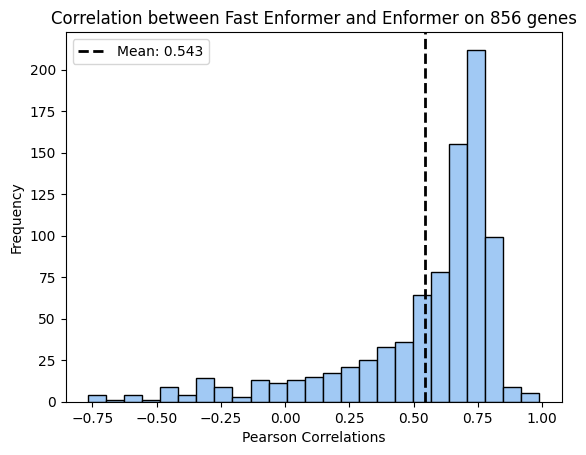

In [44]:
output_pred_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in gene_list:
    individuals = haplo_expr[gene].index
    corr, pval = stats.pearsonr(pred_expr.loc[individuals, gene].values, haplo_expr.loc[individuals, gene].values)
    output_pred_cors.loc[gene] = [corr, pval]
output_pred_cors['r'] = pd.to_numeric(output_pred_cors['r'])
output_pred_cors['pval'] = pd.to_numeric(output_pred_cors['pval'])
# Plot a pearson_corr_by_gene["human"]histogram
plt.hist(output_pred_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Correlation between Fast Enformer and Enformer on {len(gene_list)} genes')
plt.xlabel('Pearson Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_pred_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

### Worst Gene

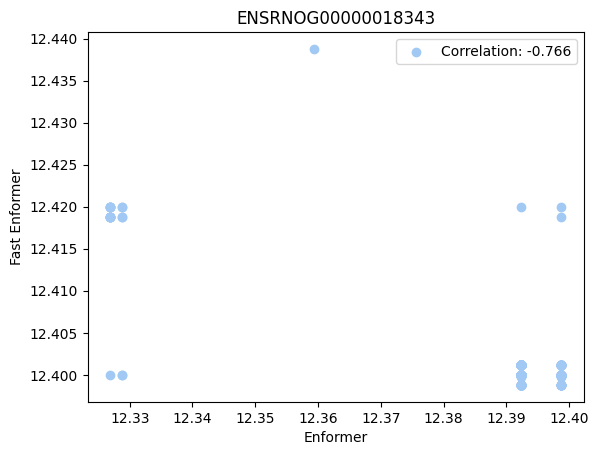

In [54]:
min_gene = output_pred_cors['r'].idxmin()
corr = output_pred_cors.loc[min_gene]["r"]
plt.scatter(pred_expr[min_gene], haplo_expr[min_gene], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")

# Add labels and title
plt.xlabel('Enformer')
plt.ylabel('Fast Enformer')
plt.title(min_gene)

# Show the plot
plt.legend()
plt.show()

### Random Gene

ENSRNOG00000019977


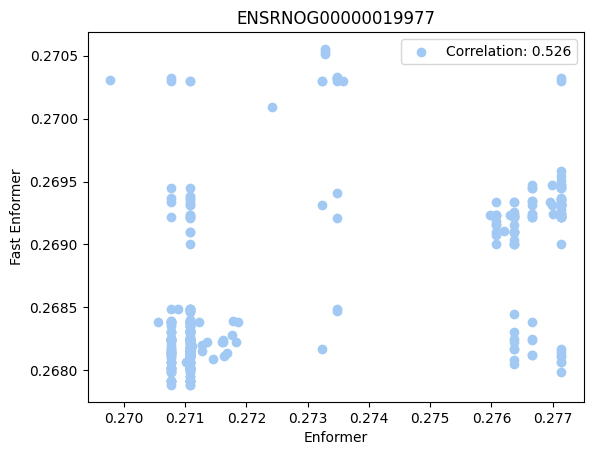

In [59]:
import random
rand_gene = random.sample(output_pred_cors.index.to_list(), 1)[0]
corr = output_pred_cors.loc[rand_gene]["r"]
plt.scatter(pred_expr[rand_gene], haplo_expr[rand_gene], marker='o', color=colors[0], label=f"Correlation: {corr:.3f}")

# Add labels and title
plt.xlabel('Enformer')
plt.ylabel('Fast Enformer')
plt.title(rand_gene)

# Show the plot
plt.legend()
plt.show()

### Misc

In [13]:
with h5py.File(f'/grand/TFXcan/imlab/data/enformer_training_data/basenji_data_h5/no_groups_popseq_revised_order/test_pop_seq.hdf5') as f:
    training_intervals = f['query_regions'][()]

In [14]:
chroms = np.unique(training_intervals[:, 0])
chr_dict = {chr: training_intervals[training_intervals[:, 0] == chr] for chr in chroms}

In [15]:
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"
outputs = []
for file in os.listdir(output_dir):
    df = pd.read_csv(os.path.join(output_dir, file), index_col=0)
    outputs.append(df)
haplo_expr = pd.concat(outputs, axis=1)

In [16]:
ortho_genes = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/rn7_hg38.ortholog_genes.txt", sep = "\t")
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", sep="\t")
gene_annot = pd.merge(ortho_genes, hg38_annot, how = "inner", left_on = "hsapiens_homolog_ensembl_gene", right_on = "ensembl_gene_id")
gene_annot = gene_annot[gene_annot['ensembl_gene_id_x'].isin(haplo_expr.columns)]

In [17]:
training_genes = []
for _, row in gene_annot.iterrows():
    rn7_gene = row['ensembl_gene_id_x']
    chr = int(row['chromosome_name'])
    tss = int(row['transcription_start_site'])
    if chr in chr_dict.keys():
        for interval in chr_dict[chr]:
            if ((tss >= interval[1]) & (tss <= interval[2])):
                training_genes.append(rn7_gene)
                continue

In [18]:
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
gene_list = gene_annot['ensembl_gene_id_x'].unique()
excluded_genes = [gene for gene in gene_list if gene not in training_genes]
pred_expr = pred_expr[gene_list]
haplo_expr = haplo_expr[gene_list]

/home/s1mi/.conda/envs/ml-python/lib/python3.10/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/s1mi/.conda/envs/ml-python/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


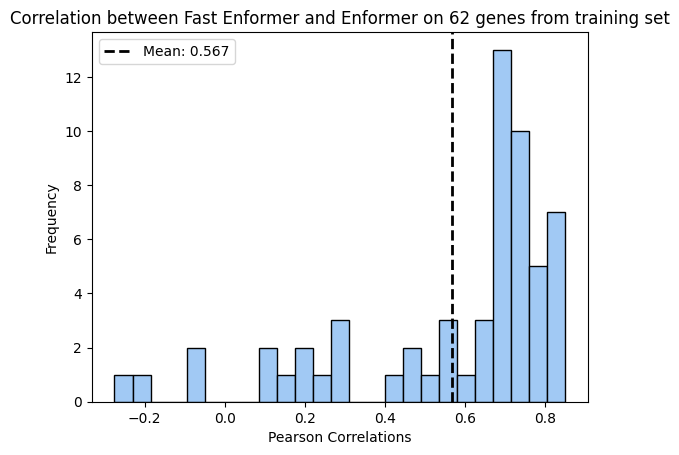

In [19]:
#| code-fold:true
output_pred_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in training_genes:
    corr, pval = stats.pearsonr(pred_expr.loc[:, gene].values, haplo_expr.loc[:, gene].values)
    output_pred_cors.loc[gene] = [corr, pval]
plt.hist(output_pred_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Correlation between Fast Enformer and Enformer on {len(training_genes)} genes from training set')
plt.xlabel('Pearson Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_pred_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

/home/s1mi/.conda/envs/ml-python/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/s1mi/.conda/envs/ml-python/lib/python3.10/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/s1mi/.conda/envs/ml-python/lib/python3.10/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


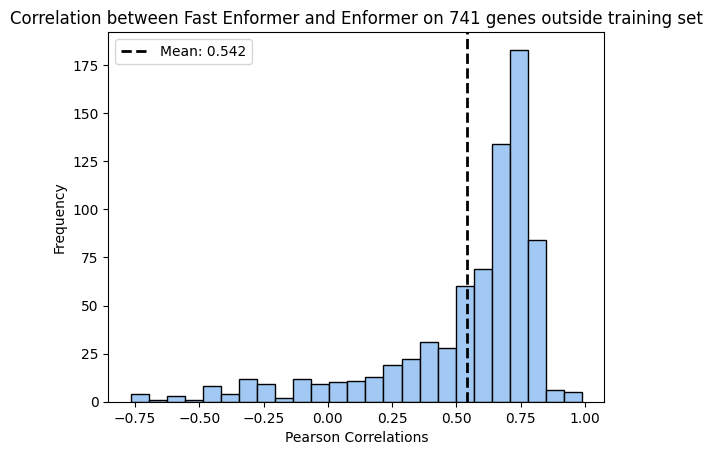

In [20]:
#| code-fold:true
output_pred_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in excluded_genes:
    corr, pval = stats.pearsonr(pred_expr.loc[:, gene].values, haplo_expr.loc[:, gene].values)
    output_pred_cors.loc[gene] = [corr, pval]
plt.hist(output_pred_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title(f'Correlation between Fast Enformer and Enformer on {len(excluded_genes)} genes outside training set')
plt.xlabel('Pearson Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_pred_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()